In [37]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch

from train_dynamics import generate_data

In [4]:
device = "cpu"
cached_fn = os.path.join("dynamics_trained", "dynamics.nf")
with open(cached_fn, "rb") as f:
    encoder = pickle.load(f)
encoder.to(device)

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=15, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBlock(
              (context_layer): Linear(in_features=12, out_features=50, bias=True)
              (linear_layers): ModuleList(
                (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): Linear(in_features=50, out_features=87, bias=True)
        )
      )
      (1): LULinear()
      (2): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=15, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBlock(
              (context_laye

In [14]:
def calc_scores(xs, Cs, k=10):
    cal_hat = encoder.sample(k, xs).detach().cpu().numpy()
    cal_tiled = np.transpose(np.tile(Cs.detach().cpu().numpy(), (k, 1, 1)), (1, 0, 2))
    cal_diff = cal_hat - cal_tiled
    cal_norms = np.linalg.norm(cal_diff, axis=-1)
    return np.min(cal_norms, axis=-1)

In [48]:
def get_coverages(cal_scores, test_scores):
    alphas = np.arange(0.025, 1.0, 0.025)
    coverages = []
    for alpha in alphas:
        q_hat = np.quantile(cal_scores, q = alpha)
        coverages.append(np.sum(test_scores < q_hat) / len(test_scores))
    return alphas, np.array(coverages)

In [45]:
cal_sims = 10_000
cal_C_hats, cal_x = generate_data(cal_sims)
cal_scores = calc_scores(cal_x, cal_C_hats)

In [46]:
test_sims = 500
(test_As, test_Bs), (test_A_hats, test_B_hats), test_x = generate_data(test_sims, return_truths=True)
test_Cs = torch.from_numpy(np.hstack([test_As.reshape(test_sims, -1), test_Bs.reshape(test_sims, -1)]))
test_C_hats = torch.from_numpy(np.hstack([test_A_hats, test_B_hats]))
    
amb_gt_test_scores = calc_scores(test_x, test_Cs)
hat_test_scores = calc_scores(test_x, test_C_hats)

In [49]:
alphas, amb_gt_coverage = get_coverages(cal_scores, amb_gt_test_scores)
alphas, hat_coverage = get_coverages(cal_scores, hat_test_scores)

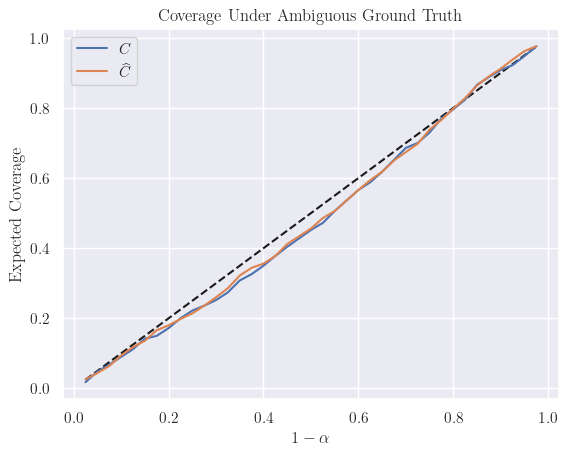

In [55]:
plt.plot(alphas, alphas, linestyle="dashed", color="k")
plt.plot(alphas, amb_gt_coverage, label="$C$")
plt.plot(alphas, hat_coverage, label="$\widehat{C}$")

plt.title(r"$\mathrm{Coverage\ Under\ Ambiguous\ Ground\ Truth}$")
plt.xlabel(r"$1-\alpha$")
plt.ylabel(r"$\mathrm{Expected\ Coverage}$")
plt.legend()